## My Plan

You can write your high-level plan for the project here.

_Note: If you haven't worked with Jupyter Notebooks before, consider reviewing [this guide](https://murillogroupmsu.com/introduction-to-jupyter-notebooks/)._

This is a task of developing a application that predicts "Which Character are You?" as to which Seinfeld character would be most likely to say the sentence/joke that was entered. The dataset is a text file containing strings of data as dialogues. To solve this problem, I am going to start with data ingestion to read the text file in jupyter and perform text mining to get the characters and their dialogues and store them as a DataFrame. In this process, I will apply several transformations in the data to remove the unnecesaary text and the unimportant characters and words. Once I have the clean dataframe ready, I will work on modeling the data to predict the character for the text entered. 

From the problem, it looks like a semantic search problem and based on our search results we will identify the character likely to speak the dialogue. If we can find the semantically similar sentences we can also find who is the speaker of those sentences and can likely speak the provided sentence. I am using NLP state-of-the-art methods to solve this problem.

I have divided my solution into following sections:

- Data Ingestion
- Cleaning and transformations
- Descriptive Statistics
- Modeling
- Deployment strategy

In [ ]:
! ls

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [39]:
!pip install -r requirements.txt

distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.7m/UNKNOWN
sysconfig: /opt/conda/include/python3.7m
user = False
home = None
root = None
prefix = None


In [ ]:
#!pip install spacy
#!pip install porter
#!pip install TextBlob==0.15.3

In [ ]:
#!pip install gensim
#!pip3 install --upgrade tensorflow-gpu
# Install TF-Hub.
#!pip3 install tensorflow-hub

In [ ]:
!python3 -m spacy download en_core_web_sm

In [316]:
#imports
import pandas as pd
import numpy as np
import re, sys
import string
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import collections
from pprint import pprint

from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords # used for preprocessing
from nltk.stem import WordNetLemmatizer # used for preprocessing
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.probability import FreqDist
from scipy.stats.stats import pearsonr 

import wordcloud
from wordcloud import WordCloud, STOPWORDS
import textblob            #to import
from textblob import TextBlob

# from sklearn.cluster import KMeans
# from sklearn.cluster import AffinityPropagation
# from sklearn.cluster import AgglomerativeClustering
import tensorflow as tf
import tensorflow_hub as hub


# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#from gensim.utils import lemmatize, simple_preprocess
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import remove_stopwords


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['re', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Data Ingestion 

In [339]:
#reading the text file 
corpus = open("corpus.txt", "r")

In [340]:
#Removing the unneccesarry lines inside the '()' and '[]' brackets between the
#characters dialogue's and converting all the strings into lowercase.

text = []
corpus = corpus.readlines()
for line in corpus:
    line = re.sub("[\(\[].*?[\)\]]", "", line)
    text.append(line.rstrip().lower())


In [341]:
#Seperating the dialogues and character names by splitting them by ':' and storing them in a list
character = []
dialogue = []
for line in text:
    if ':' in line and not line.startswith('('):
        if not line.startswith('['):
            character.append(line.split(':')[0])
            dialogue.append(line.split(':')[1].lstrip())
        

# Cleaning and transformations

In the cleaning and transformation of dataframe I have removed the punctuation and digits but kept the stop words at this stage and then created a dataframe containing the dialogue as a column and corresponding character.

In [342]:
#Checking if the length of the character list and the dialogue list matches or not to verify the extraction.
print("length of charcter list:", len(character), "Lenth of Dialogue list", len(dialogue))

length of charcter list: 54097 Lenth of Dialogue list 54097


In [343]:
# importing a string of punctuation
exclist = string.punctuation + string.digits

# remove punctuations and digits from dialogue text
table_ = str.maketrans('', '', exclist)
dialogue1 = []
for l in dialogue:
    dialogue1.append(l.translate(table_).rstrip())



In [344]:
# importing a string of punctuation
exclist = string.punctuation 

# remove punctuations from the role defined
table_ = str.maketrans('', '', exclist)
role1 = []
for l in character:
    role1.append(l.translate(table_).rstrip())

In [345]:
df = pd.DataFrame({'text': dialogue1 , 'role': role1})

#Appending the character length of dialogues
char_len = []
for i in df['text'] :
    char_len.append(len(i))

#Appending the word length of dialogues
word_len = []
for i in df['text'] :
    word_len.append(len(i.split()))

#Appending the wrod length of roles
role_len = []
for i in df['role'] :
    role_len.append(len(i.split()))

#Creating a dataframe
df = pd.DataFrame({'text': dialogue1 , 'role': role1, 'char_len':char_len, 'word_len': word_len, 'role_len': role_len})

#remove sentences with zero length
df = df[df['char_len'] != 0]
df = df[df['role_len'] <= 5] 

#number of dialogues left
print("The number of dialouge conversations:", df.shape[0])

df.head(5)


The number of dialouge conversations: 53936


,text,role,char_len,word_len,role_len
0,do you know what this is all about do you know why were here to be out this is outand out is one...,jerry,513,108,1
1,see to me that button is in the worst possible spot the second button literally makes or breaks ...,jerry,187,37,1
2,are you through,george,15,3,1
3,you do of course try on when you buy,jerry,36,9,1
4,yes it was purple i liked it i dont actually recall considering the buttons,george,75,14,1


As a part of transformation, I have cleaned the dialogue and roles and removed any punctuation of number's that were present and also counted the character length and word length of the dialogues which I would be using further in the descriptive statistics part. I have also removed dialogues that were of 0 length which came as a part of mining from the text file.

# Descriptive Statistics

### Role distribution

From the previous results we can observe that the number of unique characters are very high and we can assume not all characters must be important. So here we have a major question that we can clarify from the client that what is there measure of the a important character. Is it the number of dialogues they deliver or any other factor?

I further wanted to check the major characters by identifying the number of dialogues the character delivered.

In [346]:
def plot_bar_plot(category_count,title,xlabel,ylabel,color,img):
  plt.figure(figsize=(14,8))
  bar_plot = sns.barplot(x =category_count.index, y = category_count.values,palette=color)
  sns.set_style("white")
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  locs, labels = plt.xticks()
  plt.setp(labels, rotation=90)
  for j,i in enumerate(bar_plot.patches):
    height = i.get_height()
    bar_plot.text(i.get_x() + i.get_width()/2, height + 5, category_count[j], ha='center', va='bottom')
  plt.savefig(img,bbox_inches='tight')

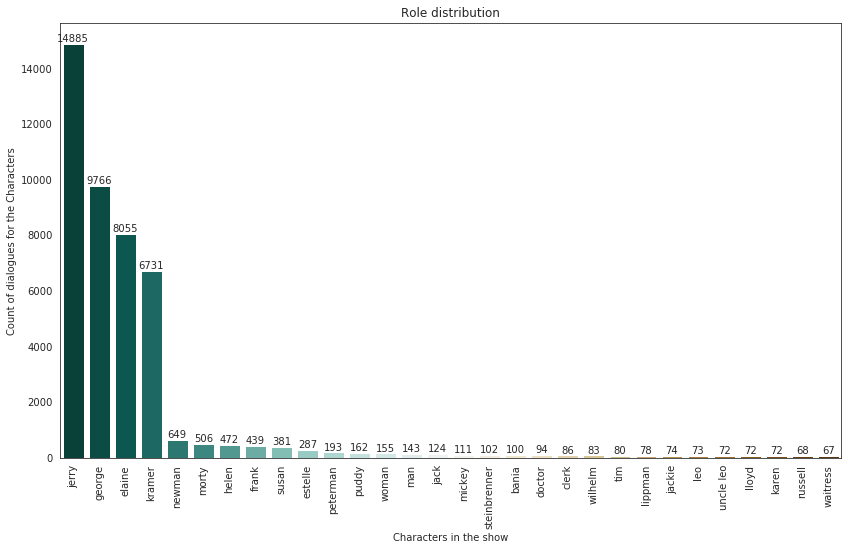

In [347]:
role = df['role'].value_counts()[:30]
plot_bar_plot(role, "Role distribution", "Characters in the show", "Count of dialogues for the Characters", 'BrBG_r', 'role.png' )

Observations: From the above plot, we can observe that there are 4 major characters which lead the show and all other character looks like supporting characters. Jerry is the main character with most dialogues in the show, then george and then elaine and kramer. Followed by these characters there are other characters but their dialogues distribution is very less and seems insignificant. 

We can ask the clients a question that is it fine to drop the characters with dialogues less than a certain number and just keep the important characters in this prediction application.


### Dialogue length by character and word distribution

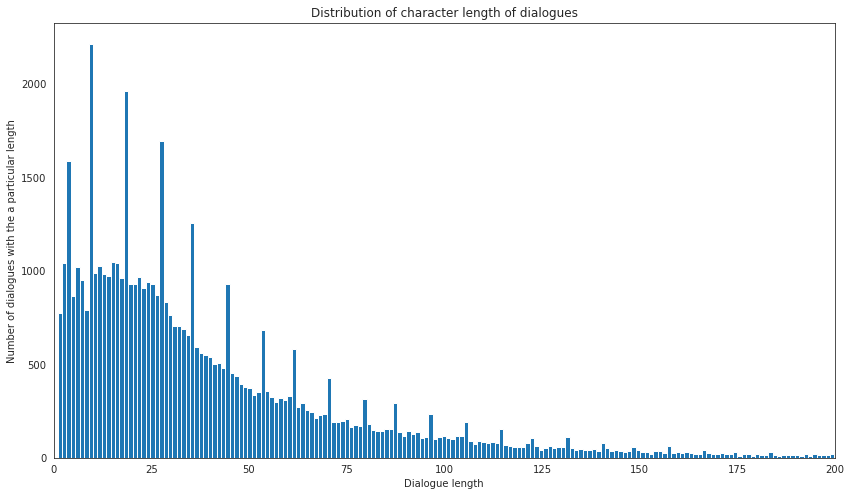

In [348]:
plt.figure(figsize = (14,8))
plt.hist(df['char_len'], bins = 1200)
plt.title("Distribution of character length of dialogues")
plt.xlabel("Dialogue length")
plt.xlim(0, 200)
plt.ylabel("Number of dialogues with the a particular length")
plt.show()

Observation : From the above plot we can observe that, the major dialogues character length is around 1 to 25 and then the number of dialogues decreases as the character length of dialogue increases showing that the converstaion between the charactes are short on a average.


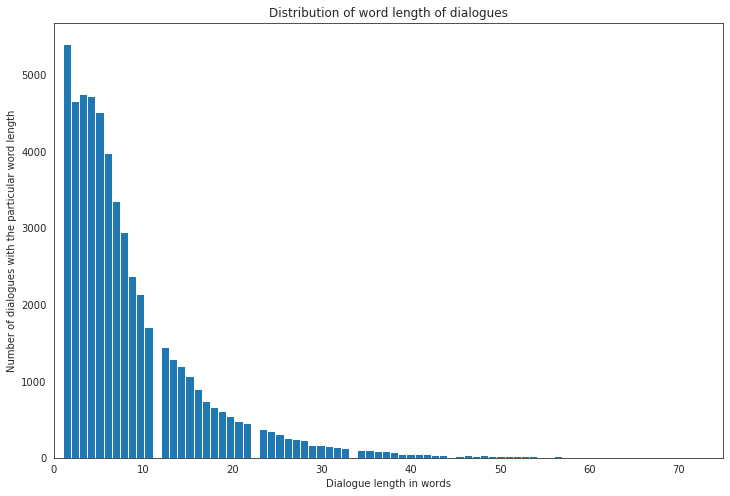

In [349]:
plt.figure(figsize = (12,8))
plt.hist(df['word_len'], bins = 300)
plt.title("Distribution of word length of dialogues")
plt.xlabel("Dialogue length in words")
plt.xlim(0, 75)
plt.ylabel("Number of dialogues with the particular word length")
plt.show()

Observation: We can observe from the above plot that the most dialogue are of very short word lengths between the range 1 to 10 and then as the word length of dialogues increases the number of dialogues increass and becomes very less are the word length of dialogues reaches around 50 which makes sense for a sitcom.

# Sentiment Analysis

As a part of descriptive statistics, I wanted to check the sentiment of the dialogues as sentiment analysis is a very important topic in textual analytics. I am using the textblob library to get the sentiment polarity of the sentences. The polarity with positive value is displays positive sentiment and negative polarity shows negative sentiment and 0 polarity shows neutral sentiment.

In [350]:
#Lemmatizing and stemming the text and removing the stop words from the dialogues for further analysis.
lemma = []
porter = PorterStemmer()
for i in df['text']:
    txt = remove_stopwords(i)
    txt = porter.stem(txt)
    sent = TextBlob(txt)
    lemma.append(" ". join([w.lemmatize() for w in sent.words]))

In [351]:
#add
df['filtered_text'] = lemma
df.head()

,text,role,char_len,word_len,role_len,filtered_text
0,do you know what this is all about do you know why were here to be out this is outand out is one...,jerry,513,108,1,know know outand single enjoyable experience life peopledid hear people talking theyre talking a...
1,see to me that button is in the worst possible spot the second button literally makes or breaks ...,jerry,187,37,1,button worst possible spot second button literally make break shirt look high nomansland look li...
2,are you through,george,15,3,1,
3,you do of course try on when you buy,jerry,36,9,1,course try buy
4,yes it was purple i liked it i dont actually recall considering the buttons,george,75,14,1,yes purple liked dont actually recall considering button


In [352]:
df['sentiment'] = df['filtered_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [353]:
print("Number of neutral dialogues:", len(df[df['sentiment'] == 0]))

Number of neutral dialogues: 38078


In [354]:
df_sentiment = df[df['sentiment'] > 0] 
print("Number of positive sentiment dialogues:", df_sentiment.shape[0])
polarity_avg = df_sentiment.groupby('role')['sentiment'].mean()
polarity_avg.sort_values(ascending= False)[:10]

Number of positive sentiment dialogues: 9782


role
bill               1.00
elaine thinking    1.00
reilly             1.00
lamar              1.00
girl               0.90
manya              0.85
mary               0.80
customer           0.80
kramer  jerry      0.80
man2               0.80
Name: sentiment, dtype: float64

In [355]:
df_sentiment = df[df['sentiment'] < 0] 
print("number of negative sentiment dialogues:", df_sentiment.shape[0])
polarity_avg = df_sentiment.groupby('role')['sentiment'].mean()
polarity_avg.sort_values(ascending= False)[:10]

number of negative sentiment dialogues: 6076


role
victoria        -0.004167
ping            -0.006250
car washer      -0.008333
steven          -0.009167
bill            -0.021212
biker           -0.022857
elaines voice   -0.023125
maitre d        -0.025000
carrie          -0.025000
georges voice   -0.027083
Name: sentiment, dtype: float64

**Observation:** From the sentiment analysis we can observe that, most of the dialogues are neutral type and on few are of positive sentiment and only 6076 are negative sentiments.


# Top 100 words by frequency

In [356]:
allwords = []
for i in df['filtered_text']:
    for word in i.split():
        allwords.append(word)
        

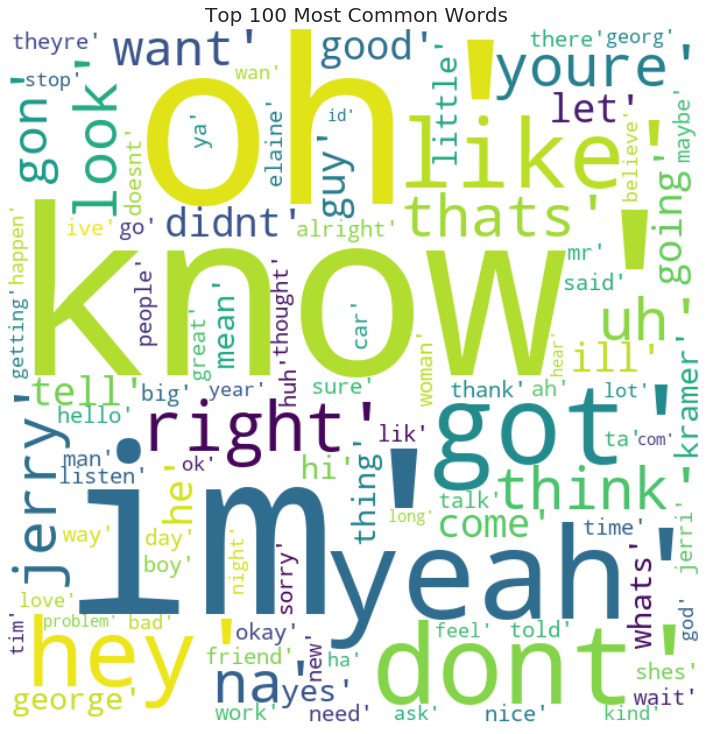

In [361]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=600, height=600, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=20)
plt.tight_layout(pad=0)
plt.show()

# Topic Modeling

Topic modeling provides a method for learning, in an unsupervised way, the topics contained in a large volume of text. Using surrounding text, topic modeling can identify words with similar meanings and distinguish between uses of words with multiple meanings. Since we are working on understanding the dialogues with similar context and meaning, topic modeling is a good technique to understand the hidden structure in our data.

For Topic Modeling I am using gensim library and I start with creating bigrams and trigrams and further process the word by perfroming lemmatization and removing stop words from the data. I am further creating term-document frequency of the corpus which will be further used by the LDA model to find topics in the dialogues.

To find the optimal number of topics in the corpus of dialogues as documents. Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. We go for the highest coherence score before the curve starts flatting. I determined the coherence score and trained the LDA model on the data with the numder of topics obtained by coherence plot.

In [135]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data_words = list(sent_to_words(df['filtered_text']))


In [136]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [137]:
data_ready = process_words(data_words) 

In [139]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [140]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           iterations=10,
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [141]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=50, step=3)

In [147]:
finalmodel = model_list[9]

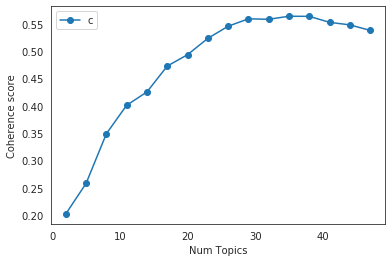

In [142]:
# Show graph
limit=50; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values,"-o")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**Observation:** From the coherence plot we can observe that the plot flattens around 29 topics. So we are going to take that LDA_model and then use it for further analysis.

In [322]:
pprint(finalmodel.print_topics())

[(19,
  '0.130*"love" + 0.113*"lik" + 0.075*"wan" + 0.074*"pretty" + 0.070*"pay" + '
  '0.065*"stuff" + 0.037*"sex" + 0.036*"goin" + 0.035*"piece" + 0.032*"chair"'),
 (13,
  '0.126*"eat" + 0.065*"miss" + 0.061*"like" + 0.057*"read" + '
  '0.052*"relationship" + 0.036*"numb" + 0.036*"person" + 0.035*"couple" + '
  '0.032*"birthday" + 0.030*"nut"'),
 (2,
  '0.079*"walk" + 0.078*"away" + 0.067*"stay" + 0.057*"mail" + 0.057*"father" '
  '+ 0.048*"drive" + 0.047*"chicken" + 0.032*"dinner" + 0.032*"exactly" + '
  '0.027*"law"'),
 (27,
  '0.168*"man" + 0.104*"woman" + 0.078*"minute" + 0.061*"date" + '
  '0.056*"remember" + 0.040*"office" + 0.038*"sign" + 0.032*"tel" + '
  '0.031*"step" + 0.024*"story"'),
 (22,
  '0.132*"bad" + 0.076*"start" + 0.055*"stupid" + 0.045*"tonight" + '
  '0.039*"apartment" + 0.031*"build" + 0.030*"house" + 0.025*"anymore" + '
  '0.024*"different" + 0.024*"game"'),
 (23,
  '0.122*"old" + 0.071*"care" + 0.068*"bathroom" + 0.068*"key" + 0.054*"lunch" '
  '+ 0.031*"moth

In [170]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts =data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=finalmodel, corpus=corpus, texts =data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,20.0,0.3522,"talk, ask, kind, people, money, elain, probabl...","[outand, single, enjoyable, experience, life, ..."
1,1,14.0,0.4023,"leave, break, open, dollar, door, happy, cmon,...","[button, bad, possible, spot, second, button, ..."
2,2,0.0,0.0345,"let, help, call, hang, leav, finish, count, fl...",[]
3,3,18.0,0.3448,"tell, gon, ill, buy, live, fix, boyfriend, new...","[course, buy]"
4,4,21.0,0.2069,"guess, actually, mind, end, suppose, funny, we...","[purple, like, actually, recall, consider, but..."
5,5,0.0,0.0345,"let, help, call, hang, leav, finish, count, fl...",[recal]
6,6,5.0,0.5172,"wait, tim, girl, clean, plan, outta, son, air,...",[tim]
7,7,0.0,0.0345,"let, help, call, hang, leav, finish, count, fl...",[senator]
8,8,3.0,0.8069,"mr, mean, meet, well, hour, seinfeld, lose, co...","[mr, seinfeld, mr, costanza]"
9,9,1.0,0.2588,"sure, feel, cut, late, park, ready, month, sho...","[sure, decaf, orange, ind]"


In [362]:
df_dominant_topic.shape

role , groupby(role, topic).count

(53936, 5)

The above dataframe shows which is the dominant topic in each dialogue and how much is the contribution along with the keyword and text.

In [327]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf[ sent_topics_sorteddf['Topic_Perc_Contrib'] == max(sent_topics_sorteddf['Topic_Perc_Contrib'])]

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
20,20.0,0.8621,"talk, ask, kind, people, money, elain, probably, grab, yesterday, able","[talk, talk, darn, talk, talk, storm, conclude, basis, talk, talk]"


The below dataframe will tell the contribution of each topic in the corpus when we have a total of 29 topics. The most contributing topic is topic 20 with 86.21 % contribution. 

In [329]:
sent_topics_sorteddf.head(30)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.7586,"let, help, call, hang, leav, finish, count, floor, kil, smart","[got, pink, lin]"
1,1.0,0.8069,"sure, feel, cut, late, park, ready, month, shoot, seat, mmm","[involve, nervous, wreck, cut, invest]"
2,2.0,0.7586,"walk, away, stay, mail, father, drive, chicken, dinner, exactly, law","[stay, stay, stay]"
3,3.0,0.8391,"mr, mean, meet, well, hour, seinfeld, lose, costanza, home, course","[lose, road, half, hour, ago]"
4,4.0,0.7586,"elaine, time, hear, today, kid, move, fact, act, face, dead","[today, today, hear]"
5,5.0,0.8391,"wait, tim, girl, clean, plan, outta, son, air, spend, prison","[wait, wait, wait, wait, wait]"
6,6.0,0.6782,"place, hate, hat, busi, crazy, naked, muffin, morn, cheese, kiss","[hat, hat]"
7,7.0,0.7586,"guy, great, sleep, sell, hot, susan, business, keep, tv, close","[guy, doll, guy, guy]"
8,8.0,0.7586,"way, happen, big, water, show, party, word, dr, marri, figure","[clear, biohazard, clear, clear]"
9,9.0,0.7586,"kramer, work, sorry, idea, throw, hard, worry, ticket, buddi, fast","[silly, john, hard, luck, honey]"


20


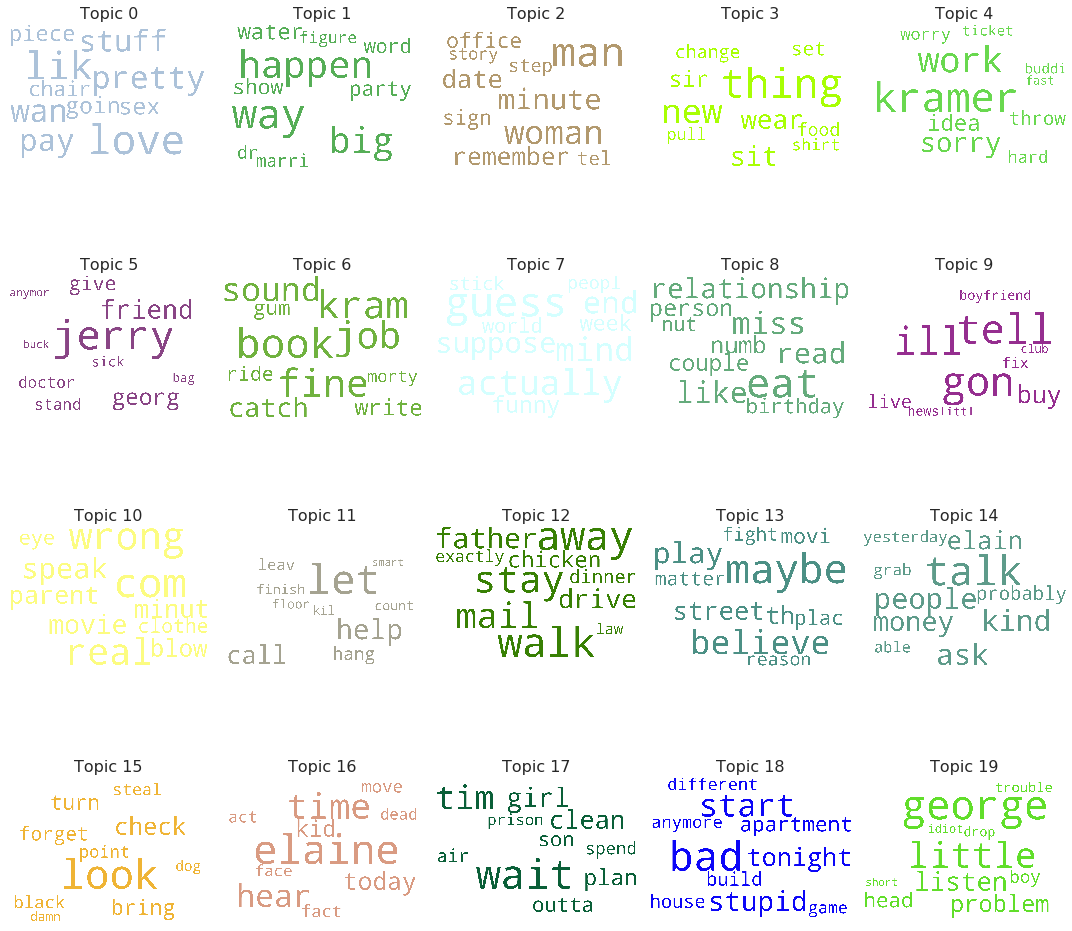

In [168]:
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = finalmodel.show_topics(num_topics=20, formatted=False)
print(len(topics))

fig, axes = plt.subplots(4, 5, figsize=(15,15), sharex=True, sharey=True)

#print(axes)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Word Cloud is a nice technique to identify important words among others. So I created word cloud of 20 topics and analysised those to understand the topics. Topic 8 shows words related to love with words like miss, relationship, couple. Topic 5 tell Jery or geoge being sick with words related doctor, sick. Topic 18 tells about house/apartment related along with start and anymore. This indicated moving to a new place. Topic 19 talks about george and some troble/problem. Topic 16 tell about hearing of death today and so on.

From the analysis of word cloud some topics look clear but still some are vague. Since sitcom have slang languages and conveys a story rather than any serious scientific well-defined contexts, the topics we got are little vague to understand and are more diffused with very common words. More work could be done to filter out word from the corpus and remove the slang words to obtain a clearer topic modeling.

# Modeling

# Doc2Vec paragraph embeddings (Baseline model)

My first approach was to used bag of words and TFIDF represention of the dialogues and get the cosine simiarilty between the dialogues. Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity is advantageous because even if the two similar documents are far apart by the Euclidean distance (due to the size of the document), chances are they may still be oriented closer together. The smaller the angle, higher the cosine similarity. 

However, tfidf or countvectorizer does not take semantics into account as they are frequency and weight based methods respectively, so, the sematic similarity is not captured using these methods which is not a good approach. When I tried this approach, the observation was that a lot of sentences had highest cosine similarities and one cannot figure out which would be the most similar sentence.

To tackle this issue, semantics needs to be considered. My next approach used is Doc2Vec:

Word2Vec is a more recent model that embeds words in a lower-dimensional vector space using a shallow neural network. The result is a set of word-vectors where vectors close together in vector space have similar meanings based on context, and word-vectors distant to each other have differing meanings. For example, strong and powerful would be close together and strong and Paris would be relatively far.

Gensim’s Word2Vec class implements this model. With the Word2Vec model, we can calculate the vectors for each word in a document. But what if we want to calculate a vector for the entire document, which is a dialogue n our case?

In Gensim, we refer to the Paragraph Vector model as Doc2Vec. The basic idea is: act as if a document has another floating word-like vector, which contributes to all training predictions, and is updated like other word-vectors, but we will call it a doc-vector. The aim is to find semantically similar dialogues to the query sentence for which we want to predict the character. The prediction would be the character whose dialogue matched the most with query vector. The understanding is if a character has spoken a sentence, he/she is most likely to speak a similar sentence.

In [372]:
#function to calculate cosine similarity
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [373]:
# Tokenization of each document
tokenized_sent = []
for s in df['text']:
    tokenized_sent.append(word_tokenize(s.lower()))

In [374]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]

In [375]:
'''
vector_size = Dimensionality of the feature vectors. most of the documents have average length 50 so 50 is selected
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
'''
## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size = 50, window = 2, min_count = 1, epochs = 100)

In [376]:
def similarity_doc2vec(testtext, model):
    test_doc = word_tokenize(testtext)
    test_doc_vector = model.infer_vector(test_doc)
    return model.docvecs.most_similar(positive = [test_doc_vector])[0]

In [377]:
# taking in the text sentence to check 
def prediction_Doc2Vec(testtext, model):
    similarity_text = similarity_doc2vec(testtext, model)
    index = similarity_text[0]
    similarity_score= similarity_text[1]
    print("Predicted Character:", df['role'][index], "\nHighest Similarity Score:", similarity_score )

### Prediction 1

In [383]:
testtext = "Frost brewed. Cold filtered. Ice bottled. We pack it in a glacier, then put it on a frozen truck driven by a polar bear."
prediction_Doc2Vec(testtext, model)

Predicted Character: george 
Highest Similarity Score: 0.6216854453086853


### Prediction 2

In [384]:
#Roger
testtext = "Hey, this guy says he knows Bricker."
prediction_Doc2Vec(testtext, model)

Predicted Character: roger 
Highest Similarity Score: 0.783502459526062


### Prediction 3

In [385]:
#man 2
testtext = "Really? What are you gonna 'bout the apartment?"
prediction_Doc2Vec(testtext, model)

Predicted Character: rita 
Highest Similarity Score: 0.7655928134918213


### Prediction 4

In [386]:
#Jackie
testtext = "Well would you tell this jury exactly what you saw at the corner of 83rd Street and Columbus?"
prediction_Doc2Vec(testtext, model)

Predicted Character: steinbrenner 
Highest Similarity Score: 0.8737338781356812


**Observation:** 

# Universal Sentence Encoder

One of the most well-performing sentence embedding techniques right now is the Universal Sentence Encoder by Google. The key feature is we can use it for multitask learning. This means that the sentence embeddings we generate can be used for multiple tasks like sentiment analysis, text classification, sentence similarity, etc, and the results of these tasks are then fed back to the model to get even better sentence vectors that before.

The most interesting part is that this encoder is based on two encoder models and we can use either of the two:

1. Transformer
2. Deep Averaging Network(DAN)

There is a trade-off between the accuracy of the results obtained and the resources required for computation, when we compare both the variants. The transformer-based model aims to achieve high model accuracy, but it requires a high amount of computation resources and increases model complexity. The memory usage and computation time for this variant rise erratically with the length of the sentence. On the contrary, the computation time linearly increases with sentence length for the DAN-based model. In the research paper, the transformer model’s time complexity has been noted as O(n2)while that of DNA model as O(n), where ‘n’ denotes the sentence length. The DAN variant aims at efficient inference despite a little reduction in achieved accuracy. 
Both of these models are capable of taking a word or a sentence as input and generating embeddings for the same. I am using DAN architechtuer for my implementation. The following is the basic flow:

1. Tokenize the sentences after converting them to lowercase
2. Depending on the type of encoder, the sentence gets converted to a 512-dimensional vector. If we use the transformer, it is similar to the encoder module of the transformer architecture and uses the self-attention mechanism. The DAN option computes the unigram and bigram embeddings first and then averages them to get a single embedding. This is then passed to a deep neural network to get a final sentence embedding of 512 dimensions.
3. These sentence embeddings are then used for various unsupervised and supervised tasks and here I am using it for sentence semantic similarity. The trained model is then again reused to generate a new 512 dimension sentence embedding.

In [388]:
#Loading the model from tensorflow hub
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [389]:
#creating the document corpus from the dataframe
corpus = []
for i in df['text']:
    corpus.append(i)

In [390]:
#Get the similar sentence using the USE embeddings and get the character who can speak the query text.
def similar_character(query_text, corpus):
    sentence_embeddings = model(corpus)
    query_vec = model([query_text])[0]
    similarity = []
    for sent in corpus:
        
        sim = cosine(query_vec, model([sent])[0])
        similarity.append(sim)
    index = np.argmax(similarity)
    print(pearsonr(model([query_text])[0], model([df['text'][index]])[0]))
    return df['role'][index]

### Prediction 1

In [391]:
query_text = "Frost brewed. Cold filtered. Ice bottled. We pack it in a glacier, then put it on a frozen truck driven by a polar bear."
print("The character that can speak the query_text is:", similar_character(query_text, corpus))

(-0.020690015252748245, 0.640451697526999)
The character that can speak the query_text is: jerry


### Prediction 2

In [392]:
query_text = "Hey, this guy says he knows Bricker."
print("The character that can speak the query_text is:", similar_character(query_text, corpus))

(1.0, 0.0)
The character that can speak the query_text is: roger


### Prediction 3

In [393]:
query_text = "Really? What are you gonna 'bout the apartment?"
print("The character that can speak the query_text is:", similar_character(query_text, corpus))

(0.2044836598897308, 3.086024016878804e-06)
The character that can speak the query_text is: jerry


### Prediction 4

In [394]:
query_text = "Well would you tell this jury exactly what you saw at the corner of 83rd Street and Columbus?"
print("The character that can speak the query_text is:", similar_character(query_text, corpus))

(0.1097792840382004, 0.012938179188226302)
The character that can speak the query_text is: steinbrenner


**Obseravation:** USE is trained to identify the similarity between the pairs of sentences. The evaluation metric is semantic textual similarity scored by humans along with Pearson’s correlations.

# Deployment strategy

Due to the Hackerank environment limitations I am not able to run the flask app that I created. so I am defining the deployment proces son Google Cloud below.

Google App Engine is a good deployment platform as it strikes a balance between abstracting away complexity and allowing you to customize the setup. Google App Engine is part of the Google Cloud Platform (GCP), which is run by Google. The first step is to download and install the Google Cloud SDK for your operating system. Once the SDK is downloaded, the next step is to build a Python Web Application which I tried to build a flask app and test on the local environment but it didn't work due to the hackerank environment. Google App Engine requires you to use a web framework for creating your web application in a Python 3 environment.

As a part of deployment process we will need three files inside the project folder we create:

1. main.py - contains Python code wrapped in a minimal implementation of the Flask web framework.
2. requirements.txt - lists all the dependencies the code needs to work properly.
3. app.yaml - helps Google App Engine decide which settings to use on its server.

I have created the main.py and added the code for the flask application also in this submission though I was unsuccessful in runnig the app due the environment limitation.

Next step is to Create requirements.txt in which we have to add all the dependencies the main code uses. Google App Engine will use requirements.txt to install the necessary Python dependencies for the project when setting it up on the server. This is similar to what we would do after creating and activating a new virtual environment locally.

The third important file is app.yaml which helps Google App Engine set up the right server environment for the code. 

To Test Locally Flask comes packaged with a development web server.To be able to run the Flask development server locally, you need to complete two steps. Google App Engine will do the same steps on its servers once you deploy your code:

1. Set up a virtual environment.
2. Install the flask package.


To set up a Python 3 virtual environment,we have navigate to the project folder on the terminal and type the following command:

!python3 -m venv venv

!source venv/bin/activate

!python3 -m pip install -r requirements.txt

We can now start Flask’s development server and interact with the Python app in our browser. We need to run the main.py Python script that starts the Flask app shows the following as output. We can click the localhost link and run the application and test in the local environment.

* Serving Flask app "main" (lazy loading)
* Environment: production
WARNING: This is a development server.
Do not use it in a production deployment.
Use a production WSGI server instead.
* Debug mode: on
* Running on http://127.0.0.1:8080/ (Press CTRL+C to quit)
* Restarting with stat
* Debugger is active!
* Debugger PIN: 315-059-987

To deploy the code on Google cloud to be accessible for everyone, we have to do set up on Google App Engine. The first step is to create a project. The project name will appear in the URL of your application. Once the project is set up we can navigate to the Google App Engine and start working on the deployment. Deployment can be done locally also since we have google cloud SDK. 

We have to type this command to start after setting the project using command line.

gcloud app deploy

We will be asked for choosing the region. Before deploying your code to Google App Engine, it’ll show you an overview of what the deployment will look like and ask you for a final confirmation. Once we press the y button the code will get deployed on App Engine. We can use the URL to access the application.


# Testing

Testing startegy could vary from problem to problem. This is more of a open ended unsupervised problem with no labels already present. We can start with Local testing and check other models to compare the performance of this model.

The second step in the ML model testing is testing as part of CI/CD. We can retrain the model from time to time as the new data get accumulated and train the model periodically or in real-time to not to lose the performance of the model on the new data.